# CGAN

*Conditional GAN*

条件付きGAN。与えた条件に沿った画像を生成する。  
「条件」を表すベクトルをGenerator, Discriminatorの両方に与える。与え方はいろいろある。

MNISTを使って、指定した数字の手書き数字画像を生成する

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

batch_size = 64
nz = 100
noize_std = 0.7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## MNIST

In [2]:
dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

sample_X = next(iter(dataloader))[0]
n_classes = len(torch.unique(dataset.targets))
w, h = sample_X.shape[-2:]
image_size = w * h
print("batch shape:", sample_X.shape)
print("n_classes:", n_classes)

batch shape: torch.Size([64, 1, 28, 28])
n_classes: 10


## Discriminator

畳み込みで得た特徴ベクトルに、ラベル（条件）のone-hotベクトルを結合して、全結合層に入力する。

In [4]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv = nn.Sequential(
#             self._conv_layer(1, 16, 4, 2, 1),
#             self._conv_layer(16, 32, 4, 2, 1),
#             self._conv_layer(32, 64, 3, 2, 0),
#             nn.Conv2d(64, 128, 3, 1, 0),
#             nn.Flatten()
#         )

#         self.fc = nn.Sequential(
#             nn.Linear(128 + n_classes, 64),
#             nn.LeakyReLU(0.2),
#             nn.Linear(64, 1),
#             nn.Sigmoid()
#         )

#     def _conv_layer(self, in_channels, out_channels, kernel_size, stride, padding):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
#             nn.BatchNorm2d(out_channels),
#             nn.LeakyReLU(0.2)
#         )

#     def forward(self, x, labels):
#         x = self.conv(x)
#         x = self._add_labels(x, labels)
#         y = self.fc(x)
#         return y

#     def _add_labels(self, x, labels):
#         labels = self._one_hot(labels)
#         x = torch.cat([x, labels], dim=1)
#         return x

#     def _one_hot(self, labels):
#         eye = torch.eye(n_classes, device=device)
#         y = eye[labels]
#         return y

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size + n_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self._eye = torch.eye(n_classes, device=device)

    def forward(self, x, labels):
        labels = self._eye[labels]
        x = x.view(batch_size, -1)
        x = torch.cat([x, labels], dim=1)
        y = self.net(x)
        return y

## Generator

今回は、条件の情報はノイズに持たせるので、ここでは何もしない

In [5]:
# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             self._convT(nz, 128, 3, 1, 0),
#             self._convT(128, 64, 3, 2, 0),
#             self._convT(64, 32, 4, 2, 1),
#             nn.ConvTranspose2d(32, 1, 4, 2, 1),
#             nn.Sigmoid()
#         )

#     def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         y = self.net(x)
#         return y

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._linear(nz, 128),
            self._linear(128, 256),
            self._linear(256, 512),
            nn.Linear(512, image_size),
            nn.Sigmoid() # 濃淡を0~1に
        )

    def _linear(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(-1, nz)
        y = self.net(x)
        y = y.view(-1, 1, w, h) # 784 -> 1x28x28
        return y

## 条件の埋め込み

条件の情報をノイズに埋め込む。対応する部分だけ少し大きな値をとるようにした。

In [5]:
def make_noise(batch_size, labels):
    n_range = int(nz / n_classes)
    z = torch.normal(0, noize_std, size=(batch_size, nz, 1, 1), device=device)
    idx = labels * n_range
    for vec, i in zip(z, idx):
        vec[i: i+n_range] += 1
    return z

こんな感じ。0の場合は0~9, 1の場合は10~19, 2の場合は20~29 ... の部分が大きくなっている

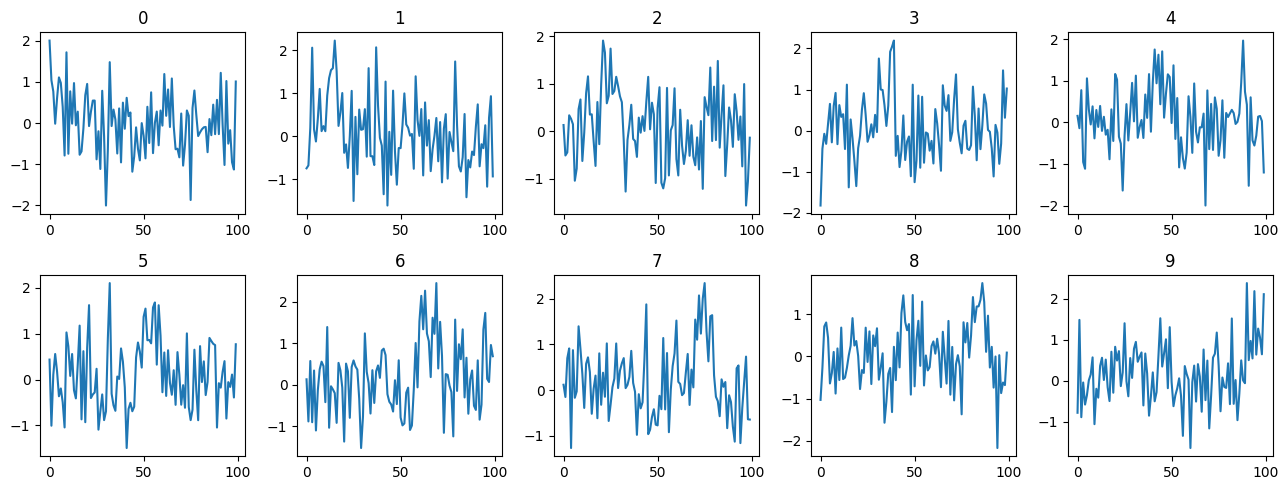

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
for label in range(10):
    plt.subplot(2, 5, label+1)
    vec = make_noise(1, torch.tensor([label])).cpu().ravel()
    plt.plot(vec)
    plt.title(label)
plt.tight_layout()

こう見るとわかり辛いが、移動平均をとるとしっかりと特徴が表れているのが分かる

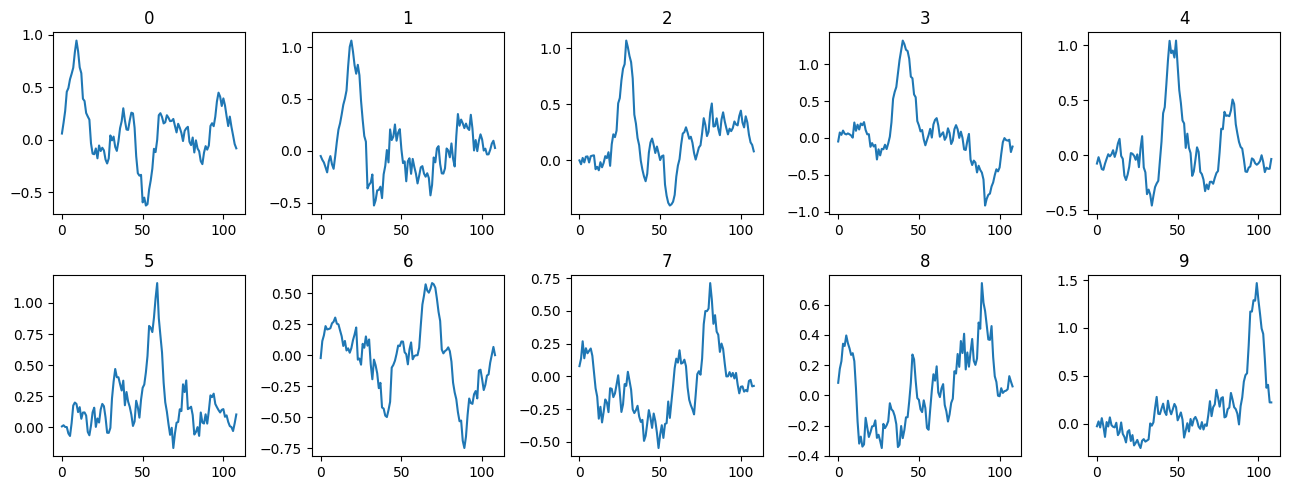

In [7]:
import numpy as np

plt.figure(figsize=(13, 5))
for label in range(10):
    plt.subplot(2, 5, label+1)
    vec = make_noise(1, torch.tensor([label])).cpu().numpy().ravel()
    vec = np.convolve(vec, np.ones(10)/10)
    plt.plot(vec)
    plt.title(label)
plt.tight_layout()

## 学習

In [8]:
def make_false_labels(labels):
    diff = torch.randint(1, n_classes, size=labels.size(), device=device)
    fake_labels = (labels + diff) % n_classes
    return fake_labels

In [9]:
def write1(netG, size=64):
    z = make_noise(10, torch.arange(10))
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, 10)
    img = transforms.functional.to_pil_image(img)
    display(img)

def write10(netG, size=64):
    z = make_noise(100, torch.arange(100) // 10)
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, 10)
    img = transforms.functional.to_pil_image(img)
    display(img)


In [10]:
fake_labels = torch.zeros(batch_size, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCELoss()

def train(netD, netG, optimD, optimG, n_epochs, write_interval=1):
    netD.train()
    netG.train()
    for epoch in range(1, n_epochs+1):
        lossD_list = []
        lossG_list = []
        for X, labels in dataloader:
            X = X.to(device)
            labels = labels.to(device)
            false_labels = make_false_labels(labels)
            optimD.zero_grad()
            optimG.zero_grad()
            z = make_noise(batch_size, labels)
            fake = netG(z)

            pred_fake = netD(fake, labels)
            pred_real_true = netD(X, labels)
            pred_real_false = netD(X, false_labels)

            loss_fake = criterion(pred_fake, fake_labels)
            loss_real_true = criterion(pred_real_true, real_labels)
            loss_real_false = criterion(pred_real_false, fake_labels)

            lossD = loss_fake + loss_real_true + loss_real_false
            lossD.backward()
            optimD.step()

            fake = netG(z)
            pred = netD(fake, labels)
            lossG = criterion(pred, real_labels)
            lossG.backward()
            optimG.step()

            lossD_list.append(lossD.item())
            lossG_list.append(lossG.item())

        print(f'{epoch:>3}epoch | lossD: {lossD}, lossG: {lossG}')
        if write_interval and epoch % write_interval == 0:
            write1(netG)

初期状態


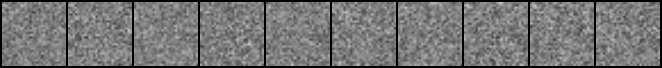

  1epoch | lossD: 0.5115920305252075, lossG: 4.15186071395874


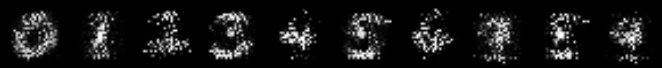

  2epoch | lossD: 0.37891632318496704, lossG: 3.1452348232269287


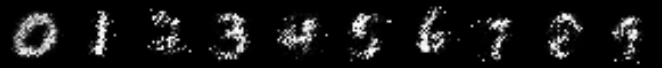

  3epoch | lossD: 0.5307225584983826, lossG: 3.5329346656799316


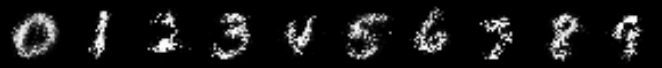

  4epoch | lossD: 0.5404582023620605, lossG: 4.231874942779541


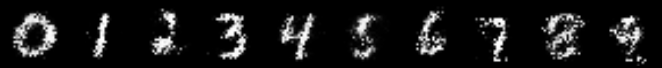

  5epoch | lossD: 0.24423198401927948, lossG: 4.430906295776367


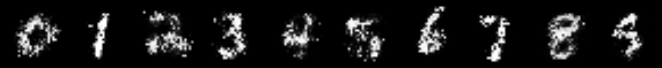

In [13]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

print('初期状態')
write1(netG)
train(netD, netG, optimD, optimG, n_epochs)

  1epoch | lossD: 0.4899711012840271, lossG: 5.092960834503174
  2epoch | lossD: 0.3416620194911957, lossG: 4.691037654876709
  3epoch | lossD: 0.27870655059814453, lossG: 4.651301383972168
  4epoch | lossD: 0.19686904549598694, lossG: 4.835020065307617
  5epoch | lossD: 0.28782254457473755, lossG: 4.5378007888793945


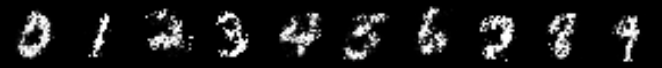

  6epoch | lossD: 0.23685234785079956, lossG: 5.447873115539551
  7epoch | lossD: 0.13905203342437744, lossG: 5.895502090454102
  8epoch | lossD: 0.23826265335083008, lossG: 6.369458198547363
  9epoch | lossD: 0.15883609652519226, lossG: 5.8002729415893555
 10epoch | lossD: 0.3510613441467285, lossG: 6.870467185974121


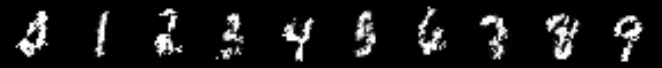

 11epoch | lossD: 0.15948495268821716, lossG: 6.636927127838135
 12epoch | lossD: 0.12852339446544647, lossG: 6.453585624694824
 13epoch | lossD: 0.35554665327072144, lossG: 5.592256546020508
 14epoch | lossD: 0.10490071028470993, lossG: 7.142510414123535
 15epoch | lossD: 0.10108286887407303, lossG: 5.961818218231201


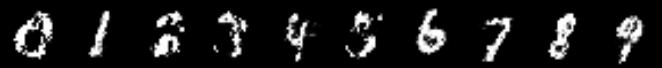

 16epoch | lossD: 0.40665072202682495, lossG: 5.5348663330078125
 17epoch | lossD: 0.3351854681968689, lossG: 5.942043304443359
 18epoch | lossD: 0.13314764201641083, lossG: 5.709266185760498
 19epoch | lossD: 0.2560670077800751, lossG: 6.395968437194824
 20epoch | lossD: 0.3059821128845215, lossG: 4.962187767028809


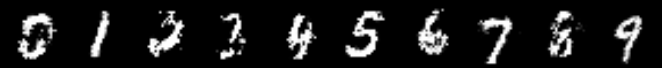

In [14]:
train(netD, netG, optimD, optimG, 30, 5)

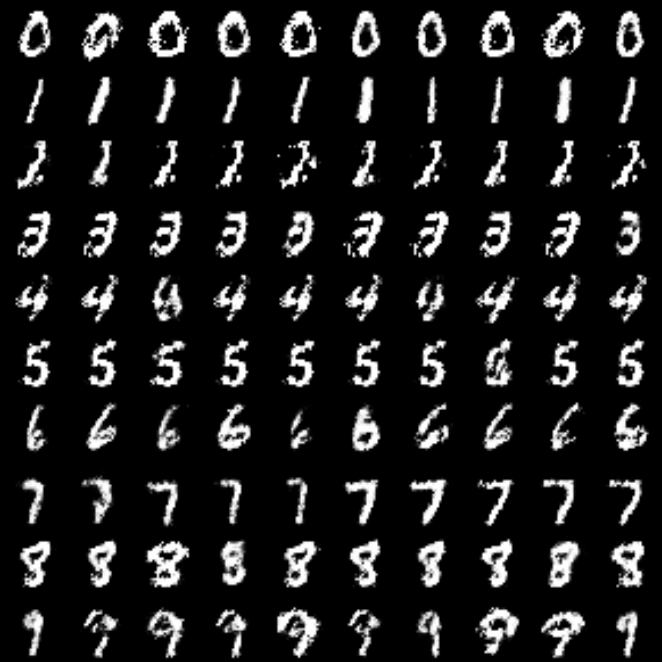

In [17]:
write10(netG)